In [5]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
from matplotlib.patches import Patch

In [6]:
######## GTEx data
### Get dictionnary of transcript and genes
gene_dic={}
with open("/home/mouren/Data/final_files_tokeep/notes/list_transript_gene_id_gencodeV41_all_proteincoding.tsv") as file:
    for line in file:            
        gene_dic[line.strip().split('\t')[0]] = line.strip().split('\t')[1].split(".")[0]

dic_ee= {}
with open("/home/mouren/Data/gtex/overlap/ee_ovlp_gtex_eqtls.tsv") as file:
    for line in file:  
        if line.strip().split('\t')[4] not in dic_ee:
            dic_ee[line.strip().split('\t')[4]] = [False,False] #first is for intern second is for extern

        if gene_dic[line.strip().split('\t')[4].split("_")[0]] == line.strip().split('\t')[9].split(".")[0]:
            dic_ee[line.strip().split('\t')[4]][0] = True
        else:
            dic_ee[line.strip().split('\t')[4]][1] = True
        
dic_neg= {}
with open("/home/mouren/Data/gtex/overlap/ctrlneg_ovlp_gtex_eqtls.tsv") as file:
    for line in file:  
        if line.strip().split('\t')[3] not in dic_neg:
            dic_neg[line.strip().split('\t')[3]] = [False,False] #first is for intern second is for extern

        if gene_dic[line.strip().split('\t')[3].split("_")[0]] == line.strip().split('\t')[10].split(".")[0]:
            dic_neg[line.strip().split('\t')[3]][0] = True
        else:
            dic_neg[line.strip().split('\t')[3]][1] = True

nb_inter_ee = [0,0,0]
for key,val in dic_ee.items():
    if val[0] == True and val[1] == True:
        nb_inter_ee[1] += 1
    elif val[0] == True and val[1] == False:
        nb_inter_ee[0] += 1
    elif val[0] == False and val[1] == True:
        nb_inter_ee[2] += 1

nb_inter_neg = [0,0,0]
for key,val in dic_neg.items():
    if val[0] == True and val[1] == True:
        nb_inter_neg[1] += 1
    elif val[0] == True and val[1] == False:
        nb_inter_neg[0] += 1
    elif val[0] == False and val[1] == True:
        nb_inter_neg[2] += 1

res_dic_ee = {}
res_dic_ee["Ctrl+"] = [(139300*100)/404325,0,0] #just count number of uniq element with an interaction for pos
res_dic_ee["Ctrl-"] = [nb_inter_neg[0]*100/13253,nb_inter_neg[1]*100/13253,nb_inter_neg[2]*100/13253]
res_dic_ee["EE"] = [(nb_inter_ee[0]*100)/13481,(nb_inter_ee[1]*100)/13481,(nb_inter_ee[2]*100)/13481]

print(sum((res_dic_ee["Ctrl+"])))
print(sum((res_dic_ee["Ctrl-"])))
print(sum((res_dic_ee["EE"])))

34.45248253261609
10.11846374405795
26.222090349380608


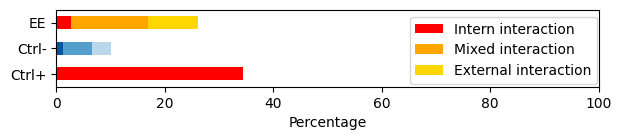

In [7]:
######## GTEx plot
cell_names = list(res_dic_ee.keys())
bar_positions = range(len(cell_names))

plt.figure(figsize=(7, 1))

red_values = [values[0] for values in res_dic_ee.values()]
gold_values = [values[1] for values in res_dic_ee.values()]
orange_values = [values[2] for values in res_dic_ee.values()]

# Define the new colors for the 'EE' bar
original_color_for_intern_ctrl = sns.color_palette("Blues")[5]
original_color_for_mixed_ctrl = sns.color_palette("Blues")[3]
original_color_for_external_ctrl = sns.color_palette("Blues")[1]  

# Define the original colors for the 'Ctrl-' bar
new_color_for_intern_ee = 'red'
new_color_for_mixed_ee = 'orange'
new_color_for_external_ee = 'gold'

colors_for_intern = [original_color_for_intern_ctrl if i == 1 else new_color_for_intern_ee for i in bar_positions]
colors_for_mixed = [original_color_for_mixed_ctrl if i == 1 else new_color_for_mixed_ee for i in bar_positions]
colors_for_external = [original_color_for_external_ctrl if i == 1 else new_color_for_external_ee for i in bar_positions]

# Plot each segment with its corresponding color
plt.barh(bar_positions, red_values, color=colors_for_intern, height=0.5)
plt.barh(bar_positions, gold_values, color=colors_for_mixed, left=red_values, height=0.5)
plt.barh(bar_positions, orange_values, color=colors_for_external, left=[r + y for r, y in zip(red_values, gold_values)], height=0.5)

plt.yticks(bar_positions, cell_names) #, size=5)

plt.xlabel('Percentage')
plt.xlim(0, 100)

c1 = Patch(facecolor="red", label='Intern interaction')
c2 = Patch(facecolor="orange", label='Mixed interaction')
c3 = Patch(facecolor="gold", label='External interaction')

plt.legend(handles=[c1,c2,c3],bbox_to_anchor=(1.01, 1))
plt.margins(x=100,y=0.1)

plt.show()

In [8]:
######## ENCODE-rE2G data
### Get dictionnary of transcript and genes
gene_dic={}
with open("/home/mouren/Data/hiC/transcriptId_GeneID_hg38.tsv") as file:
    for line in file:            
        gene_dic[line.strip().split('\t')[0]] = line.strip().split('\t')[1]

### Load bilans 
dfee = pd.read_csv("/home/mouren/Data/encode-rE2G/bilan_ee_encode_re2g_overlap.tsv", sep='\t', index_col=0)
dfneg = pd.read_csv("/home/mouren/Data/encode-rE2G/bilan_neg_encode_re2g_overlap.tsv", sep='\t', index_col=0)

cells_ee = {"Ctrl-":[0,0,0],"EE":[0,0,0]}

### Calculate across all tissues 
for index in dfee.index: #EE
    transcript_gene = gene_dic[index.split("_")[0]]
    intern = False
    extern = False
    for column in dfee.columns:
        if dfee.at[index, column] != "0" and dfee.at[index, column] != 0:
            for i in dfee.at[index, column].split(','):
                if i == transcript_gene:
                    intern = True
                else:
                    extern = True

                if intern == True and extern == True:
                    break
            
            if intern == True and extern == True:
                cells_ee["EE"][2] += 1
                break

    if intern == True and extern == False:
        cells_ee["EE"][0] += 1
    elif intern == False and extern == True:
        cells_ee["EE"][1] += 1

for index in dfneg.index: #EE
    transcript_gene = gene_dic[index.split("_")[0]]
    intern = False
    extern = False
    for column in dfneg.columns:
        if dfneg.at[index, column] != "0" and dfneg.at[index, column] != 0:
            for i in dfneg.at[index, column].split(','):
                if i == transcript_gene:
                    intern = True
                else:
                    extern = True

                if intern == True and extern == True:
                    break
            
            if intern == True and extern == True:
                cells_ee["Ctrl-"][2] += 1
                break

    if intern == True and extern == False:
        cells_ee["Ctrl-"][0] += 1
    elif intern == False and extern == True:
        cells_ee["Ctrl-"][1] += 1

res_dic_ee = {}
for key,values in cells_ee.items():
    if key == "EE":
        entry = [(values[0]*100)/13481,(values[1]*100)/13481,(values[2]*100)/13481]
    elif key == "Ctrl-":
        entry = [(values[0]*100)/13253,(values[1]*100)/13253,(values[2]*100)/13253]

    res_dic_ee[key] = entry

# pos number is obtained like this : 
# awk '{print $4}' /mnt/project/exonhancer/ZENODO_REPO/Interaction_data/ENCODE-rE2G/pos_encode_re2g_overlap_raw.tsv |sort -u |wc -l
res_dic_ee["Ctrl+"] = [(269125*100)/404325,0,0] #just count number of uniq element with an interaction for pos

print(sum((res_dic_ee["Ctrl+"])))
print(sum((res_dic_ee["Ctrl-"])))
print(sum((res_dic_ee["EE"])))

66.56155320596055
5.478004980004528
53.089533417402265


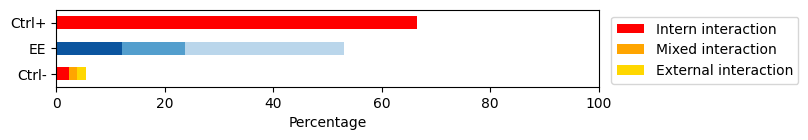

In [9]:
####### ENCODE-rE2G plot
cell_names = list(res_dic_ee.keys())
bar_positions = range(len(cell_names))

plt.figure(figsize=(7, 1))

red_values = [values[0] for values in res_dic_ee.values()]
gold_values = [values[1] for values in res_dic_ee.values()]
orange_values = [values[2] for values in res_dic_ee.values()]

# Define the new colors for the 'EE' bar
original_color_for_intern_ctrl = sns.color_palette("Blues")[5]
original_color_for_mixed_ctrl = sns.color_palette("Blues")[3]
original_color_for_external_ctrl = sns.color_palette("Blues")[1]  

# Define the original colors for the 'Ctrl-' bar
new_color_for_intern_ee = 'red'
new_color_for_mixed_ee = 'orange'
new_color_for_external_ee = 'gold'

colors_for_intern = [original_color_for_intern_ctrl if i == 1 else new_color_for_intern_ee for i in bar_positions]
colors_for_mixed = [original_color_for_mixed_ctrl if i == 1 else new_color_for_mixed_ee for i in bar_positions]
colors_for_external = [original_color_for_external_ctrl if i == 1 else new_color_for_external_ee for i in bar_positions]

# Plot each segment with its corresponding color
plt.barh(bar_positions, red_values, color=colors_for_intern, height=0.5)
plt.barh(bar_positions, gold_values, color=colors_for_mixed, left=red_values, height=0.5)
plt.barh(bar_positions, orange_values, color=colors_for_external, left=[r + y for r, y in zip(red_values, gold_values)], height=0.5)

plt.yticks(bar_positions, cell_names) #, size=5)

plt.xlabel('Percentage')
plt.xlim(0, 100)

c1 = Patch(facecolor="red", label='Intern interaction')
c2 = Patch(facecolor="orange", label='Mixed interaction')
c3 = Patch(facecolor="gold", label='External interaction')

plt.legend(handles=[c1,c2,c3],bbox_to_anchor=(1.01, 1))
plt.margins(x=100,y=0.1)

plt.show()

In [14]:
####### Pcap-HiC data
### Get dictionnary of transcript and genes
gene_dic={}
with open("/home/mouren/Data/hiC/transcriptId_GeneID_hg38.tsv") as file:
    for line in file:            
        gene_dic[line.strip().split('\t')[0]] = line.strip().split('\t')[1]

### Load bilans 
dfee = pd.read_csv("/mnt/project/exonhancer/ZENODO_REPO/Interaction_data/pCap-HiC/bilan_promHiC_EE_allInteractions_normalized.tsv", sep='\t', index_col=0)
dfneg = pd.read_csv("/mnt/project/exonhancer/ZENODO_REPO/Interaction_data/pCap-HiC/bilan_promHiC_neg_allInteractions_normalized.tsv", sep='\t', index_col=0)

cells_ee = {"Ctrl-":[0,0,0],"EE":[0,0,0]}

### Calculate across all tissues 
for index in dfee.index: #EE
    transcript_gene = gene_dic[index.split("_")[0]]
    intern = False
    extern = False
    for column in dfee.columns:
        if dfee.at[index, column] != "0" and dfee.at[index, column] != 0:
            for i in dfee.at[index, column].split(','):
                if i == transcript_gene:
                    intern = True
                else:
                    extern = True

                if intern == True and extern == True:
                    break
            
            if intern == True and extern == True:
                cells_ee["EE"][2] += 1
                break

    if intern == True and extern == False:
        cells_ee["EE"][0] += 1
    elif intern == False and extern == True:
        cells_ee["EE"][1] += 1

for index in dfneg.index: #EE
    transcript_gene = gene_dic[index.split("_")[0]]
    intern = False
    extern = False
    for column in dfneg.columns:
        if dfneg.at[index, column] != "0" and dfneg.at[index, column] != 0:
            for i in dfneg.at[index, column].split(','):
                if i == transcript_gene:
                    intern = True
                else:
                    extern = True

                if intern == True and extern == True:
                    break
            
            if intern == True and extern == True:
                cells_ee["Ctrl-"][2] += 1
                break

    if intern == True and extern == False:
        cells_ee["Ctrl-"][0] += 1
    elif intern == False and extern == True:
        cells_ee["Ctrl-"][1] += 1

res_dic_ee_tmp = {}
for key,values in cells_ee.items():
    if key == "EE":
        entry = [(values[0]*100)/13481,(values[1]*100)/13481,(values[2]*100)/13481]
    elif key == "Ctrl-":
        entry = [(values[0]*100)/13253,(values[1]*100)/13253,(values[2]*100)/13253]

    res_dic_ee_tmp[key] = entry

# pos number is obtained like this : 
# awk '{print $4}' promHiC_allctrlpos_interactions.tsv |sort -u |wc -l -> 232103
res_dic_ee_tmp["Ctrl+"] = [(232103*100)/404325,0,0] #just count number of uniq element with an interaction for pos

print(sum((res_dic_ee_tmp["Ctrl+"])))
print(sum((res_dic_ee_tmp["Ctrl-"])))
print(sum((res_dic_ee_tmp["EE"])))

57.40505781240339
42.36776578887799
70.64757807284326


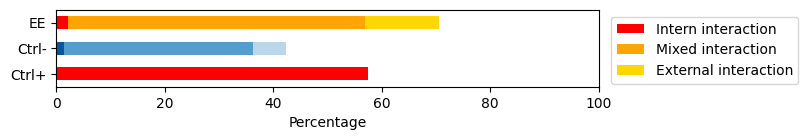

In [17]:
####### Pcap-HiC plot
## do the same for hic 
custom_order = ['Ctrl+', 'Ctrl-', 'EE']
res_dic_ee = {key: res_dic_ee_tmp[key] for key in custom_order}

cell_names = list(res_dic_ee.keys())
bar_positions = range(len(cell_names))

plt.figure(figsize=(7, 1))

red_values = [values[0] for values in res_dic_ee.values()]
gold_values = [values[1] for values in res_dic_ee.values()]
orange_values = [values[2] for values in res_dic_ee.values()]

# Define the new colors for the 'EE' bar
original_color_for_intern_ctrl = sns.color_palette("Blues")[5]
original_color_for_mixed_ctrl = sns.color_palette("Blues")[3]
original_color_for_external_ctrl = sns.color_palette("Blues")[1]  

# Define the original colors for the 'Ctrl-' bar
new_color_for_intern_ee = 'red'
new_color_for_mixed_ee = 'orange'
new_color_for_external_ee = 'gold'

colors_for_intern = [original_color_for_intern_ctrl if i == 1 else new_color_for_intern_ee for i in bar_positions]
colors_for_mixed = [original_color_for_mixed_ctrl if i == 1 else new_color_for_mixed_ee for i in bar_positions]
colors_for_external = [original_color_for_external_ctrl if i == 1 else new_color_for_external_ee for i in bar_positions]

# Plot each segment with its corresponding color
plt.barh(bar_positions, red_values, color=colors_for_intern, height=0.5)
plt.barh(bar_positions, gold_values, color=colors_for_mixed, left=red_values, height=0.5)
plt.barh(bar_positions, orange_values, color=colors_for_external, left=[r + y for r, y in zip(red_values, gold_values)], height=0.5)

plt.yticks(bar_positions, cell_names) #, size=5)

plt.xlabel('Percentage')
plt.xlim(0, 100)

c1 = Patch(facecolor="red", label='Intern interaction')
c2 = Patch(facecolor="orange", label='Mixed interaction')
c3 = Patch(facecolor="gold", label='External interaction')

plt.legend(handles=[c1,c2,c3],bbox_to_anchor=(1.01, 1))
plt.margins(x=100,y=0.1)

plt.savefig("/home/mouren/Images/tls1/main_figures/PcapHiC_bar_total.pdf", format="pdf", bbox_inches="tight")

plt.show()